# 結果に多少差はみられた
#### 次は実際に作った予測機がどの季節にどれくらい当てているのかを見る。(年間の的中数はわかってるから予測のむずかしい季節が分かるかも)

In [31]:
#いろいろインポート
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot as plt
import seaborn
from pandas import DataFrame
from tqdm import tqdm
from imblearn.under_sampling import RandomUnderSampler #アンダーサンプリング用
import pickle
# 機械学習用
from sklearn.cluster import KMeans #クラスタリング用
from sklearn.ensemble import RandomForestClassifier#ランダムフォレスト
from copy import deepcopy as cp
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression as LR

import datetime
import graph
pd.set_option('display.width',400)#勝手に改行コードを入れられるのを防ぐ

In [32]:
def make_PCA_df(PCA_arr):#PCAで削減したものは二次元配列で帰ってくるので、それをデータフレームにして返す関数
    X=[0]*len(PCA_arr)
    Y=[0]*len(PCA_arr)
    index=0
    for arr in PCA_arr:
        X[index]=arr[0]
        Y[index]=arr[1]
        index+=1
    return pd.DataFrame({'X':X,'Y':Y})

def making_pred_df(df):
    pred_race_df=df
    #pred_race_df=pred_race_df.drop(["Unnamed: 0"],axis=1)#csvファイルについている名無しの列を削除
    result_df=pred_race_df
    result_df=result_df.drop(["racer_1_ID","racer_2_ID","racer_3_ID","racer_4_ID","racer_5_ID","racer_6_ID",],axis=1)#IDはいらないので削除
    result_df=result_df.replace(0.0000,{"racer_1_ave_st_time":0.22})#新人のave_st_timeを0.22に
    result_df=result_df.replace(0.0000,{"racer_2_ave_st_time":0.22})
    result_df=result_df.replace(0.0000,{"racer_3_ave_st_time":0.22})
    result_df=result_df.replace(0.0000,{"racer_4_ave_st_time":0.22})
    result_df=result_df.replace(0.0000,{"racer_5_ave_st_time":0.22})
    result_df=result_df.replace(0.0000,{"racer_6_ave_st_time":0.22})
    result_df=result_df.replace(0.0000,{"racer_1_doub_win":0.02})#新人の着に絡む確率ave_st_timeを0.02に(新人の半期の偏差から導出)
    result_df=result_df.replace(0.0000,{"racer_2_doub_win":0.02})
    result_df=result_df.replace(0.0000,{"racer_3_doub_win":0.02})
    result_df=result_df.replace(0.0000,{"racer_4_doub_win":0.02})
    result_df=result_df.replace(0.0000,{"racer_5_doub_win":0.02})
    result_df=result_df.replace(0.0000,{"racer_6_doub_win":0.02})
    #ダミー変数化
    result_df_dummie=result_df
    race_dummie_df=pd.get_dummies(result_df_dummie['number_race'])#number_raceをダミー化
    for column, val in race_dummie_df.iteritems():
        result_df_dummie['race_{}'.format(int(column))]=val
    result_df_dummie=result_df_dummie.drop('number_race',axis=1)

    cols=list(result_df_dummie.columns)
    male_cols=[s for s in cols if 'male' in s]#性別を示すカラムを取り出す

    #===========================新規、性別の取り出し機能が良くなかったため作り直す
    empty_arr=[0]*len(result_df_dummie)
    for col in male_cols:
        for number in np.arange(0,2,1):
              result_df_dummie['{}_{}'.format(col,int(number))]=empty_arr
        male_dummie_df=pd.get_dummies(result_df_dummie[col])#性別をダミー化
        for column, val in male_dummie_df.iteritems():
              result_df_dummie['{}_{}'.format(col,int(column))]=val
        result_df_dummie=result_df_dummie.drop('{}'.format(col),axis=1)

    cols=list(result_df_dummie.columns)
    moter_cols=[s for s in cols if '_mo' in s]#モーター番号を示すカラムを取り出す
    boat_cols=[s for s in cols if '_bo' in s]#ボート番号を示すカラムを取り出す
    #boat もmoterも番号は1~99とする
    numbers=np.arange(1, 100, 1)
    empty_arr=[0]*len(result_df_dummie)
    for col in moter_cols:
        for number in numbers:
              result_df_dummie['{}_{}'.format(col,int(number))]=empty_arr
        moter_dummie_df=pd.get_dummies(result_df_dummie[col])#モータ番号をダミー化
        for column, val in moter_dummie_df.iteritems():
              result_df_dummie['{}_{}'.format(col,int(column))]=val
        result_df_dummie=result_df_dummie.drop('{}'.format(col),axis=1)

    #boat番号をダミー化
    for col in boat_cols:
        for number in numbers:
              result_df_dummie['{}_{}'.format(col,int(number))]=empty_arr
        boat_dummie_df=pd.get_dummies(result_df_dummie[col])#boat番号をダミー化
        for column, val in boat_dummie_df.iteritems():
              result_df_dummie['{}_{}'.format(col,int(column))]=val
        result_df_dummie=result_df_dummie.drop('{}'.format(col),axis=1)
    result_df=result_df_dummie



    #クラスタリング
    #分けてみるクラスタの数は[8,10]の2個
    #cluster_target_df　　trainのデータからリザルトと配当金を取り除いたもの
    target_num_cluster=[8,10]
    #test_clustaring_df=train_has_PCA_df
    clustar_target_df=result_df
    clustaring_df=clustar_target_df
    for num_cluster in target_num_cluster:
        pred = KMeans(random_state=0,n_clusters=num_cluster).fit_predict(clustar_target_df)
        clustaring_df['num={}'.format(num_cluster)]=pred

    model_df=clustaring_df

    return model_df

### dateのデータを追加したバージョンからクラスタリングを行わないように方針変更（精度が下がったため）

In [33]:
def making_pred_date_df(df):#配当金、着の情報は切りぬかなくてもうまいことやってくれる。
    pred_race_df=df
    #pred_race_df=pred_race_df.drop(["Unnamed: 0"],axis=1)#csvファイルについている名無しの列を削除
    result_df=pred_race_df
    result_df=result_df.drop(["racer_1_ID","racer_2_ID","racer_3_ID","racer_4_ID","racer_5_ID","racer_6_ID",],axis=1)#IDはいらないので削除
    result_df=result_df.replace(0.0000,{"racer_1_ave_st_time":0.22})#新人のave_st_timeを0.22に
    result_df=result_df.replace(0.0000,{"racer_2_ave_st_time":0.22})
    result_df=result_df.replace(0.0000,{"racer_3_ave_st_time":0.22})
    result_df=result_df.replace(0.0000,{"racer_4_ave_st_time":0.22})
    result_df=result_df.replace(0.0000,{"racer_5_ave_st_time":0.22})
    result_df=result_df.replace(0.0000,{"racer_6_ave_st_time":0.22})
    result_df=result_df.replace(0.0000,{"racer_1_doub_win":0.02})#新人の着に絡む確率ave_st_timeを0.02に(新人の半期の偏差から導出)
    result_df=result_df.replace(0.0000,{"racer_2_doub_win":0.02})
    result_df=result_df.replace(0.0000,{"racer_3_doub_win":0.02})
    result_df=result_df.replace(0.0000,{"racer_4_doub_win":0.02})
    result_df=result_df.replace(0.0000,{"racer_5_doub_win":0.02})
    result_df=result_df.replace(0.0000,{"racer_6_doub_win":0.02})
    #配当金と結果の情報を横によけておく。(仮のデータフレームに格納する）=========================================================
    #クラスタリングに使わないカラムを取り除く
    drop_col_names=['result_com','money']
    train_drops_df=pd.DataFrame(columns=drop_col_names)
    train_drops_df['result_com']=result_df['result_com']
    train_drops_df['money']=result_df['money']
    result_df=result_df.drop(drop_col_names,axis=1)
    #==============================================================================================================================
    #ダミー変数化
    #月をダミー化
    empty_arr=[0]*len(result_df)
    for number in np.arange(1,13,1):
        result_df['month_{}'.format(int(number))]=empty_arr
    dummie_df=pd.get_dummies(result_df['month'])#月をダミー化
    for column, val in dummie_df.iteritems():
        result_df['month_{}'.format(int(column))]=val

        
    #季節のダミー化   
    empty_arr=[0]*len(result_df)
    seasons=['sp','su','au','wi']
    for season in seasons:
        result_df['{}'.format(number)]=empty_arr
    dummie_df=pd.get_dummies(result_df['season'])#季節をダミー化
    for column, val in dummie_df.iteritems():
        result_df['{}'.format(column)]=val


    #開催日数のダミー化
    empty_arr=[0]*len(result_df)
    ranges=[1,2,3,4,5,6,7]#年末がおかしくなるっぽいから、一応からむだけ作っておく　
    for number in ranges:
        result_df['range_{}'.format(int(number))]=empty_arr
    dummie_df=pd.get_dummies(result_df['range_date'])#開催日数をダミー化
    for column, val in dummie_df.iteritems():
        result_df['range_{}'.format(int(column))]=val
        
    #開催日数のうちの何日目かのダミー化
    empty_arr=[0]*len(result_df)
    num_dates=[1,2,3,4,5,6,7]
    for number in num_dates:
        result_df['num_date_{}'.format(int(number))]=empty_arr
    dummie_df=pd.get_dummies(result_df['num_date'])#開催日数をダミー化
    for column, val in dummie_df.iteritems():
        result_df['num_date_{}'.format(int(column))]=val
        
    result_df=result_df.drop(['month','season','range_date','num_date'],axis=1)#ダミー化し終わったカラムは削除する
    #レース番号のダミー化===============================================
    result_df_dummie=result_df
    race_dummie_df=pd.get_dummies(result_df_dummie['number_race'])#number_raceをダミー化
    for column, val in race_dummie_df.iteritems():
        result_df_dummie['race_{}'.format(int(column))]=val
    result_df_dummie=result_df_dummie.drop('number_race',axis=1)    
    #===========================新規、性別の取り出し機能が良くなかったため作り直す
    cols=list(result_df_dummie.columns)
    male_cols=[s for s in cols if 'male' in s]#性別を示すカラムを取り出す
    empty_arr=[0]*len(result_df_dummie)
    for col in male_cols:
        for number in np.arange(0,2,1):
              result_df_dummie['{}_{}'.format(col,int(number))]=empty_arr
        male_dummie_df=pd.get_dummies(result_df_dummie[col])#性別をダミー化
        for column, val in male_dummie_df.iteritems():
              result_df_dummie['{}_{}'.format(col,int(column))]=val
        result_df_dummie=result_df_dummie.drop('{}'.format(col),axis=1)

    cols=list(result_df_dummie.columns)
    moter_cols=[s for s in cols if '_mo' in s]#モーター番号を示すカラムを取り出す
    boat_cols=[s for s in cols if '_bo' in s]#ボート番号を示すカラムを取り出す
    #boat もmoterも番号は1~99とする
    numbers=np.arange(1, 100, 1)
    empty_arr=[0]*len(result_df_dummie)
    for col in moter_cols:
        for number in numbers:
              result_df_dummie['{}_{}'.format(col,int(number))]=empty_arr
        moter_dummie_df=pd.get_dummies(result_df_dummie[col])#モータ番号をダミー化
        for column, val in moter_dummie_df.iteritems():
              result_df_dummie['{}_{}'.format(col,int(column))]=val
        result_df_dummie=result_df_dummie.drop('{}'.format(col),axis=1)

    #boat番号をダミー化
    for col in boat_cols:
        for number in numbers:
              result_df_dummie['{}_{}'.format(col,int(number))]=empty_arr
        boat_dummie_df=pd.get_dummies(result_df_dummie[col])#boat番号をダミー化
        for column, val in boat_dummie_df.iteritems():
              result_df_dummie['{}_{}'.format(col,int(column))]=val
        result_df_dummie=result_df_dummie.drop('{}'.format(col),axis=1)
    result_df=result_df_dummie


    result_df['result_com']=train_drops_df['result_com']#正解ラベルを戻してあげる
    result_df['money']=train_drops_df['money']#配当金を戻してあげる
    model_df=result_df

    return model_df

In [34]:
#予測の検証データを2019年に絞り込んで、欠損地の加工を施す
train_df=pd.read_csv('../csv/train_asiya_date.csv',encoding='utf-8')
train_df=train_df.drop(["Unnamed: 0"],axis=1)
test_date_df=train_df[train_df['year']==2019]
test_df=test_date_df.copy()
date_cols=['date','year','month','day','num_date','range_date','season']
date_df=pd.DataFrame(index=test_date_df.index)
for col in date_cols:
    date_df[col]=test_date_df[col]
    test_df=test_df.drop(col,axis=1)
money_col=test_df['money']#配当金情報の削除
test_df=test_df.drop('money',axis=1)
result_col=test_df['result_com']#着の組み合わせ
test_df=test_df.drop('result_com',axis=1)
test_race_df=making_pred_df(test_df)#モデルに突っ込むだけの状態に加工（新人選手の情報、欠損地加工とダミー化）
test_race_df

,racer_1_age,racer_1_ave_st,racer_1_doub,racer_1_rank,racer_2_age,racer_2_ave_st,racer_2_doub,racer_2_rank,racer_3_age,racer_3_ave_st,...,racer_6_bo_92,racer_6_bo_93,racer_6_bo_94,racer_6_bo_95,racer_6_bo_96,racer_6_bo_97,racer_6_bo_98,racer_6_bo_99,num=8,num=10
15171,31.0,0.16,0.453,4,27.0,0.16,0.170,1,51.0,0.20,...,0,0,0,0,0,0,0,0,4,5
15172,52.0,0.18,0.328,3,34.0,0.21,0.121,1,23.0,0.12,...,0,0,0,0,0,0,0,0,3,1
15173,38.0,0.16,0.525,4,57.0,0.22,0.078,2,34.0,0.16,...,0,0,0,0,0,0,0,0,2,9
15174,31.0,0.19,0.344,3,38.0,0.18,0.450,4,34.0,0.20,...,0,0,0,0,0,0,0,0,1,7
15175,32.0,0.20,0.245,2,47.0,0.15,0.388,3,32.0,0.17,...,0,0,0,0,0,0,0,0,2,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17285,45.0,0.16,0.234,2,39.0,0.18,0.250,2,45.0,0.20,...,0,0,0,0,0,0,0,0,3,6
17286,34.0,0.18,0.404,3,31.0,0.16,0.279,2,54.0,0.16,...,0,0,0,0,0,0,0,0,5,2
17287,32.0,0.19,0.398,3,38.0,0.18,0.349,3,44.0,0.16,...,0,0,0,0,0,0,0,0,5,2
17288,32.0,0.16,0.483,4,52.0,0.17,0.426,3,45.0,0.16,...,0,0,0,0,0,0,0,0,4,6


In [35]:
test_race_df

,racer_1_age,racer_1_ave_st,racer_1_doub,racer_1_rank,racer_2_age,racer_2_ave_st,racer_2_doub,racer_2_rank,racer_3_age,racer_3_ave_st,...,racer_6_bo_92,racer_6_bo_93,racer_6_bo_94,racer_6_bo_95,racer_6_bo_96,racer_6_bo_97,racer_6_bo_98,racer_6_bo_99,num=8,num=10
15171,31.0,0.16,0.453,4,27.0,0.16,0.170,1,51.0,0.20,...,0,0,0,0,0,0,0,0,4,5
15172,52.0,0.18,0.328,3,34.0,0.21,0.121,1,23.0,0.12,...,0,0,0,0,0,0,0,0,3,1
15173,38.0,0.16,0.525,4,57.0,0.22,0.078,2,34.0,0.16,...,0,0,0,0,0,0,0,0,2,9
15174,31.0,0.19,0.344,3,38.0,0.18,0.450,4,34.0,0.20,...,0,0,0,0,0,0,0,0,1,7
15175,32.0,0.20,0.245,2,47.0,0.15,0.388,3,32.0,0.17,...,0,0,0,0,0,0,0,0,2,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17285,45.0,0.16,0.234,2,39.0,0.18,0.250,2,45.0,0.20,...,0,0,0,0,0,0,0,0,3,6
17286,34.0,0.18,0.404,3,31.0,0.16,0.279,2,54.0,0.16,...,0,0,0,0,0,0,0,0,5,2
17287,32.0,0.19,0.398,3,38.0,0.18,0.349,3,44.0,0.16,...,0,0,0,0,0,0,0,0,5,2
17288,32.0,0.16,0.483,4,52.0,0.17,0.426,3,45.0,0.16,...,0,0,0,0,0,0,0,0,4,6


### 既存の予測機でテスト

In [36]:
model3 = pickle.load(open('../pickle_data/model/model_com3_dep6_per121.sav', 'rb'))
model4 = pickle.load(open('../pickle_data/model/model_com4_dep7_per131.sav', 'rb'))
model5 = pickle.load(open('../pickle_data/model/model_com5_dep8_per122.sav', 'rb'))
model7 = pickle.load(open('../pickle_data/model/model_com7_dep7_per146.sav', 'rb'))
model13 = pickle.load(open('../pickle_data/model/model_com13_dep6_per115.sav', 'rb'))
model14= pickle.load(open('../pickle_data/model/model_com14_dep4_per123.sav', 'rb'))

model3_pred=model3.predict(test_race_df)
model4_pred=model4.predict(test_race_df)
model5_pred=model5.predict(test_race_df)
model7_pred=model7.predict(test_race_df)
model13_pred=model13.predict(test_race_df)
model14_pred=model14.predict(test_race_df)

pred_df=pd.DataFrame({'pred_3':model3_pred,
                        'pred_4':model4_pred,
                        'pred_5':model5_pred,
                        'pred_7':model7_pred,
                        'pred_13':model13_pred,
                        'pred_14':model14_pred
                        },index=test_race_df.index)
#レースの情報を戻す。
pred_df['result_com']=result_col
pred_df=pd.concat([pred_df, date_df], axis=1)

### 予測があっているかのフラグを持ったカラムを作成

In [37]:
target_coms=[3,4,5,7,13,14]#今回、芦屋で対象の予測組
pred_flags=[]#正答のカラムを作るための結果と予測の比較結果を持ったリスト(正解:1  外れ:0)
for index,row in pred_df.iterrows():
    result=row['result_com']
    flag=0
    for com_num in target_coms:
        if 1==row['pred_{}'.format(com_num)]:#発生あり予測があるか
            if result==com_num:#予測があっているか
                flag=1
            else:
                pass
        else:
            pass
    pred_flags.append(flag)


In [38]:
#予測結果の正答結果を持ったカラムを持たせる。
result_df=pred_df.copy()
result_df['right_pred']=pred_flags
result_df.to_csv('date_analysis_base.csv',encoding='utf-8')
result_df

,pred_3,pred_4,pred_5,pred_7,pred_13,pred_14,result_com,date,year,month,day,num_date,range_date,season,right_pred
15171,0,0,0,0,0,0,7,2019-04-01,2019,4,1,1,6,sp,0
15172,0,0,1,1,0,0,5,2019-04-01,2019,4,1,1,6,sp,1
15173,0,0,1,0,0,0,6,2019-04-01,2019,4,1,1,6,sp,0
15174,1,0,0,0,0,0,31,2019-04-01,2019,4,1,1,6,sp,0
15175,0,0,0,0,0,0,1,2019-04-01,2019,4,1,1,6,sp,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17285,0,0,0,0,0,0,80,2019-03-25,2019,3,25,6,6,sp,0
17286,0,0,0,0,0,0,20,2019-03-25,2019,3,25,6,6,sp,0
17287,0,0,0,0,0,0,2,2019-03-25,2019,3,25,6,6,sp,0
17288,0,0,0,0,0,0,5,2019-03-25,2019,3,25,6,6,sp,0


In [39]:
append_s

14    2
13    2
5     2
7     1
4     1
3     1
Name: result_com, dtype: int64

In [40]:
#正しく判断できたレースのみを残す（ほんとは投票を行ったものの数農地の割合のほうがよさそうだけど・・）
#グラフをP描画する用のdfを作成する。
right_df=result_df[result_df['right_pred']==1] 
month_graph_df=pd.DataFrame(columns=[3,4,5,7,13,14])
for month_num in np.arange(1,13,1):#月の番号
    sp_month_df=right_df[right_df['month']==month_num]#月のデータ
    append_s=sp_month_df['result_com'].value_counts()
    month_graph_df.loc['{}月'.format(month_num)]=append_s
month_graph_df=month_graph_df.fillna(0)
month_graph_df['sum']=month_graph_df[3]+month_graph_df[4]+month_graph_df[5]+month_graph_df[7]+month_graph_df[13]+month_graph_df[14]
month_graph_df['月']=month_graph_df.index


In [41]:
month_graph_df=month_graph_df.fillna(0)
month_graph_df

,3,4,5,7,13,14,sum,月
1月,0.0,2.0,0.0,2.0,2.0,0.0,6.0,1月
2月,1.0,0.0,0.0,0.0,1.0,0.0,2.0,2月
3月,6.0,3.0,1.0,1.0,0.0,2.0,13.0,3月
4月,6.0,5.0,7.0,1.0,1.0,1.0,21.0,4月
5月,2.0,1.0,3.0,3.0,4.0,0.0,13.0,5月
6月,4.0,2.0,3.0,4.0,2.0,3.0,18.0,6月
7月,1.0,2.0,4.0,3.0,5.0,1.0,16.0,7月
8月,4.0,1.0,2.0,0.0,0.0,3.0,10.0,8月
9月,1.0,5.0,3.0,3.0,0.0,0.0,12.0,9月
10月,9.0,0.0,3.0,2.0,0.0,0.0,14.0,10月


145.0


c:\users\nabe0\desktop\nabepy\env\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 26376 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\nabe0\desktop\nabepy\env\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 26376 missing from current font.
  font.set_text(s, 0, flags=flags)
c:\users\nabe0\desktop\nabepy\env\lib\site-packages\matplotlib\backends\backend_agg.py:176: RuntimeWarning: Glyph 26376 missing from current font.
  font.load_char(ord(s), flags=flags)


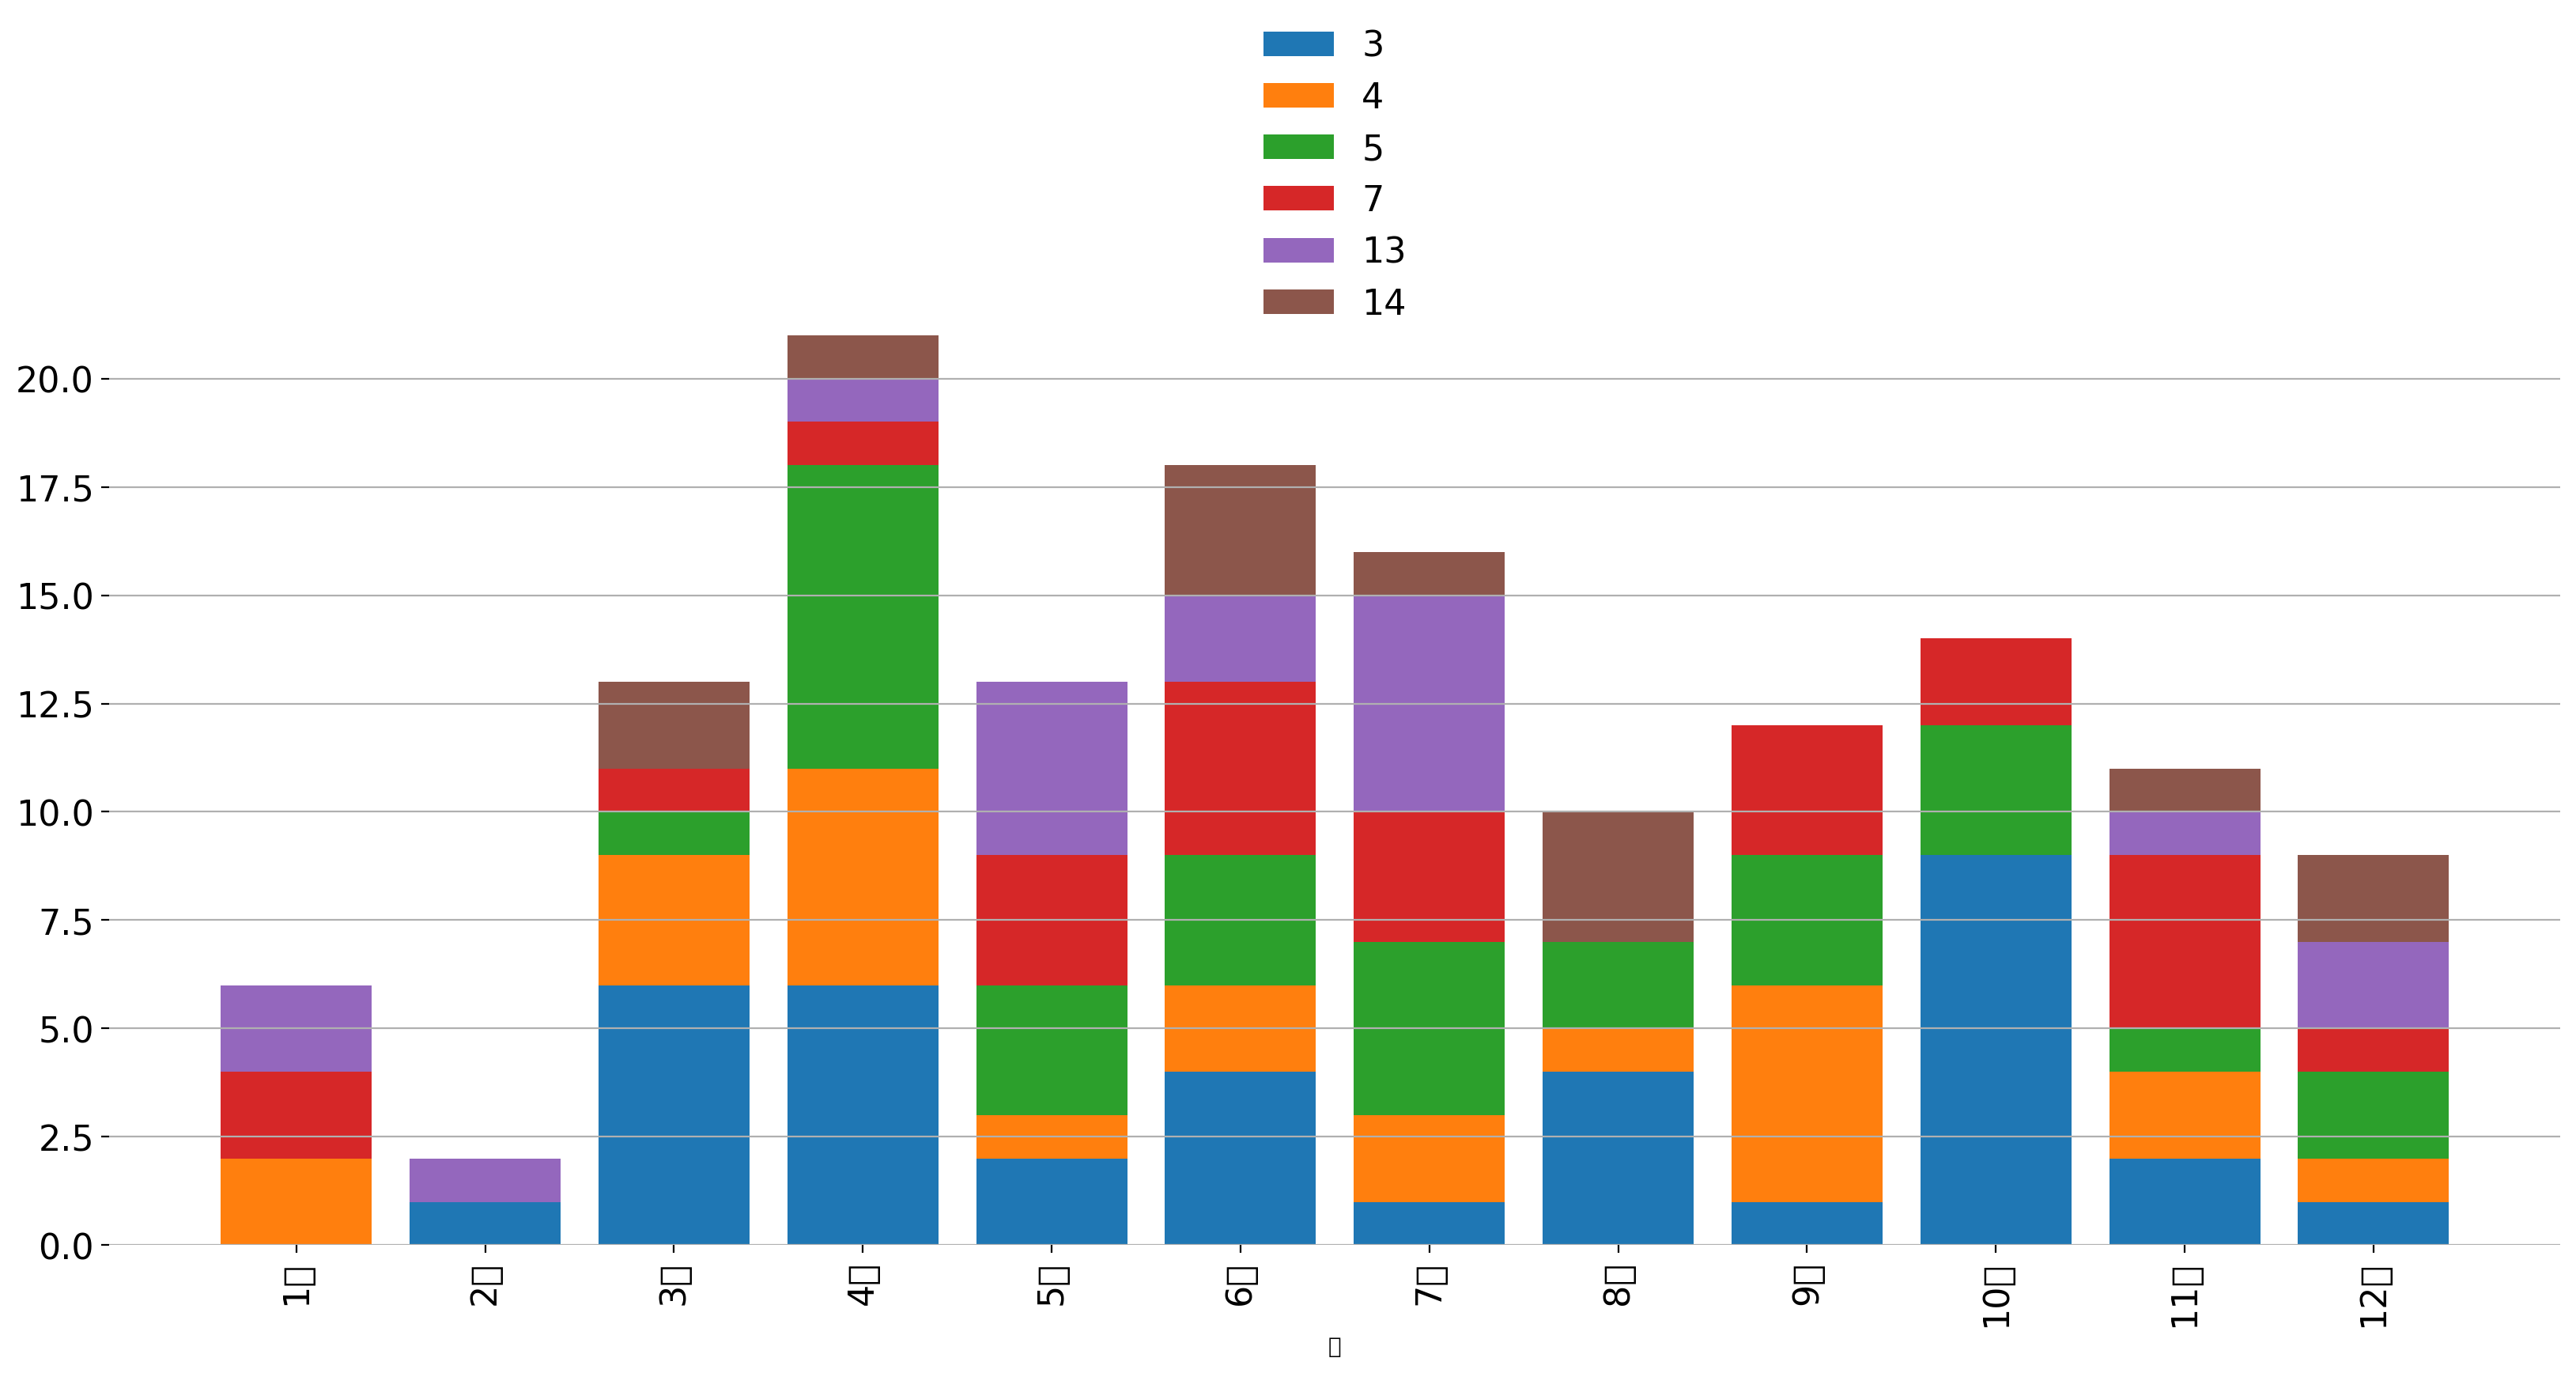

In [42]:
X_col='月'
Y_cols=['3','4','5','7','13','14']
month_graph_df=month_graph_df.rename(columns={3: '3', 4: '4', 5: '5', 7: '7', 13: '13', 14: '14'})
graph.stack_bar(X_col, Y_cols,month_graph_df)
print(month_graph_df['sum'].sum())

In [43]:
month_graph_df['sum'].sum()

145.0

In [44]:
#予測の検証データを2019年に絞り込んで、欠損地の加工を施す
train_df=pd.read_csv('../csv/train_asiya_date.csv',encoding='utf-8')
train_df=train_df.drop(["Unnamed: 0"],axis=1)
test_date_df=train_df[train_df['year']==2020]
test_df=test_date_df.copy()
date_cols=['date','year','month','day','num_date','range_date','season']
date_df=pd.DataFrame(index=test_date_df.index)
for col in date_cols:
    date_df[col]=test_date_df[col]
    test_df=test_df.drop(col,axis=1)
money_col=test_df['money']#配当金情報の削除
test_df=test_df.drop('money',axis=1)
result_col=test_df['result_com']#着の組み合わせ
test_df=test_df.drop('result_com',axis=1)
test_race_df=making_pred_df(test_df)#モデルに突っ込むだけの状態に加工（新人選手の情報、欠損地加工とダミー化）

model3 = pickle.load(open('../pickle_data/model/model_com3_dep6_per121.sav', 'rb'))
model4 = pickle.load(open('../pickle_data/model/model_com4_dep7_per131.sav', 'rb'))
model5 = pickle.load(open('../pickle_data/model/model_com5_dep8_per122.sav', 'rb'))
model7 = pickle.load(open('../pickle_data/model/model_com7_dep7_per146.sav', 'rb'))
model13 = pickle.load(open('../pickle_data/model/model_com13_dep6_per115.sav', 'rb'))
model14= pickle.load(open('../pickle_data/model/model_com14_dep4_per123.sav', 'rb'))

model3_pred=model3.predict(test_race_df)
model4_pred=model4.predict(test_race_df)
model5_pred=model5.predict(test_race_df)
model7_pred=model7.predict(test_race_df)
model13_pred=model13.predict(test_race_df)
model14_pred=model14.predict(test_race_df)

pred_df=pd.DataFrame({'pred_3':model3_pred,
                        'pred_4':model4_pred,
                        'pred_5':model5_pred,
                        'pred_7':model7_pred,
                        'pred_13':model13_pred,
                        'pred_14':model14_pred
                        },index=test_race_df.index)
#レースの情報を戻す。
pred_df['result_com']=result_col
pred_df=pd.concat([pred_df, date_df], axis=1)
target_coms=[3,4,5,7,13,14]#今回、芦屋で対象の予測組
pred_flags=[]#正答のカラムを作るための結果と予測の比較結果を持ったリスト(正解:1  外れ:0)
for index,row in pred_df.iterrows():
    result=row['result_com']
    flag=0
    for com_num in target_coms:
        if 1==row['pred_{}'.format(com_num)]:#発生あり予測があるか
            if result==com_num:#予測があっているか
                flag=1
            else:
                pass
        else:
            pass
    pred_flags.append(flag)
#予測結果の正答結果を持ったカラムを持たせる。
result_df=pred_df.copy()
result_df['right_pred']=pred_flags
result_df.to_csv('date_analysis_base.csv',encoding='utf-8')
#正しく判断できたレースのみを残す（ほんとは投票を行ったものの数農地の割合のほうがよさそうだけど・・）
#グラフをP描画する用のdfを作成する。
right_df=result_df[result_df['right_pred']==1] 
month_graph_df=pd.DataFrame(columns=[3,4,5,7,13,14])
for month_num in np.arange(1,13,1):#月の番号
    sp_month_df=right_df[right_df['month']==month_num]#月のデータ
    append_s=sp_month_df['result_com'].value_counts()
    month_graph_df.loc['{}月'.format(month_num)]=append_s
month_graph_df=month_graph_df.fillna(0)
month_graph_df['sum']=month_graph_df[3]+month_graph_df[4]+month_graph_df[5]+month_graph_df[7]+month_graph_df[13]+month_graph_df[14]
month_graph_df['月']=month_graph_df.index
month_graph_df=month_graph_df.fillna(0)
month_graph_df


,3,4,5,7,13,14,sum,月
1月,3.0,1.0,2.0,5.0,3.0,0.0,14.0,1月
2月,1.0,1.0,1.0,1.0,5.0,0.0,9.0,2月
3月,1.0,0.0,2.0,0.0,1.0,2.0,6.0,3月
4月,1.0,2.0,1.0,2.0,2.0,2.0,10.0,4月
5月,1.0,4.0,0.0,3.0,4.0,1.0,13.0,5月
6月,1.0,2.0,3.0,0.0,2.0,2.0,10.0,6月
7月,0.0,1.0,1.0,3.0,3.0,0.0,8.0,7月
8月,0.0,1.0,1.0,4.0,3.0,1.0,10.0,8月
9月,1.0,1.0,2.0,1.0,2.0,0.0,7.0,9月
10月,0.0,0.0,1.0,1.0,3.0,0.0,5.0,10月


99.0


c:\users\nabe0\desktop\nabepy\env\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 26376 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\nabe0\desktop\nabepy\env\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 26376 missing from current font.
  font.set_text(s, 0, flags=flags)
c:\users\nabe0\desktop\nabepy\env\lib\site-packages\matplotlib\backends\backend_agg.py:176: RuntimeWarning: Glyph 26376 missing from current font.
  font.load_char(ord(s), flags=flags)


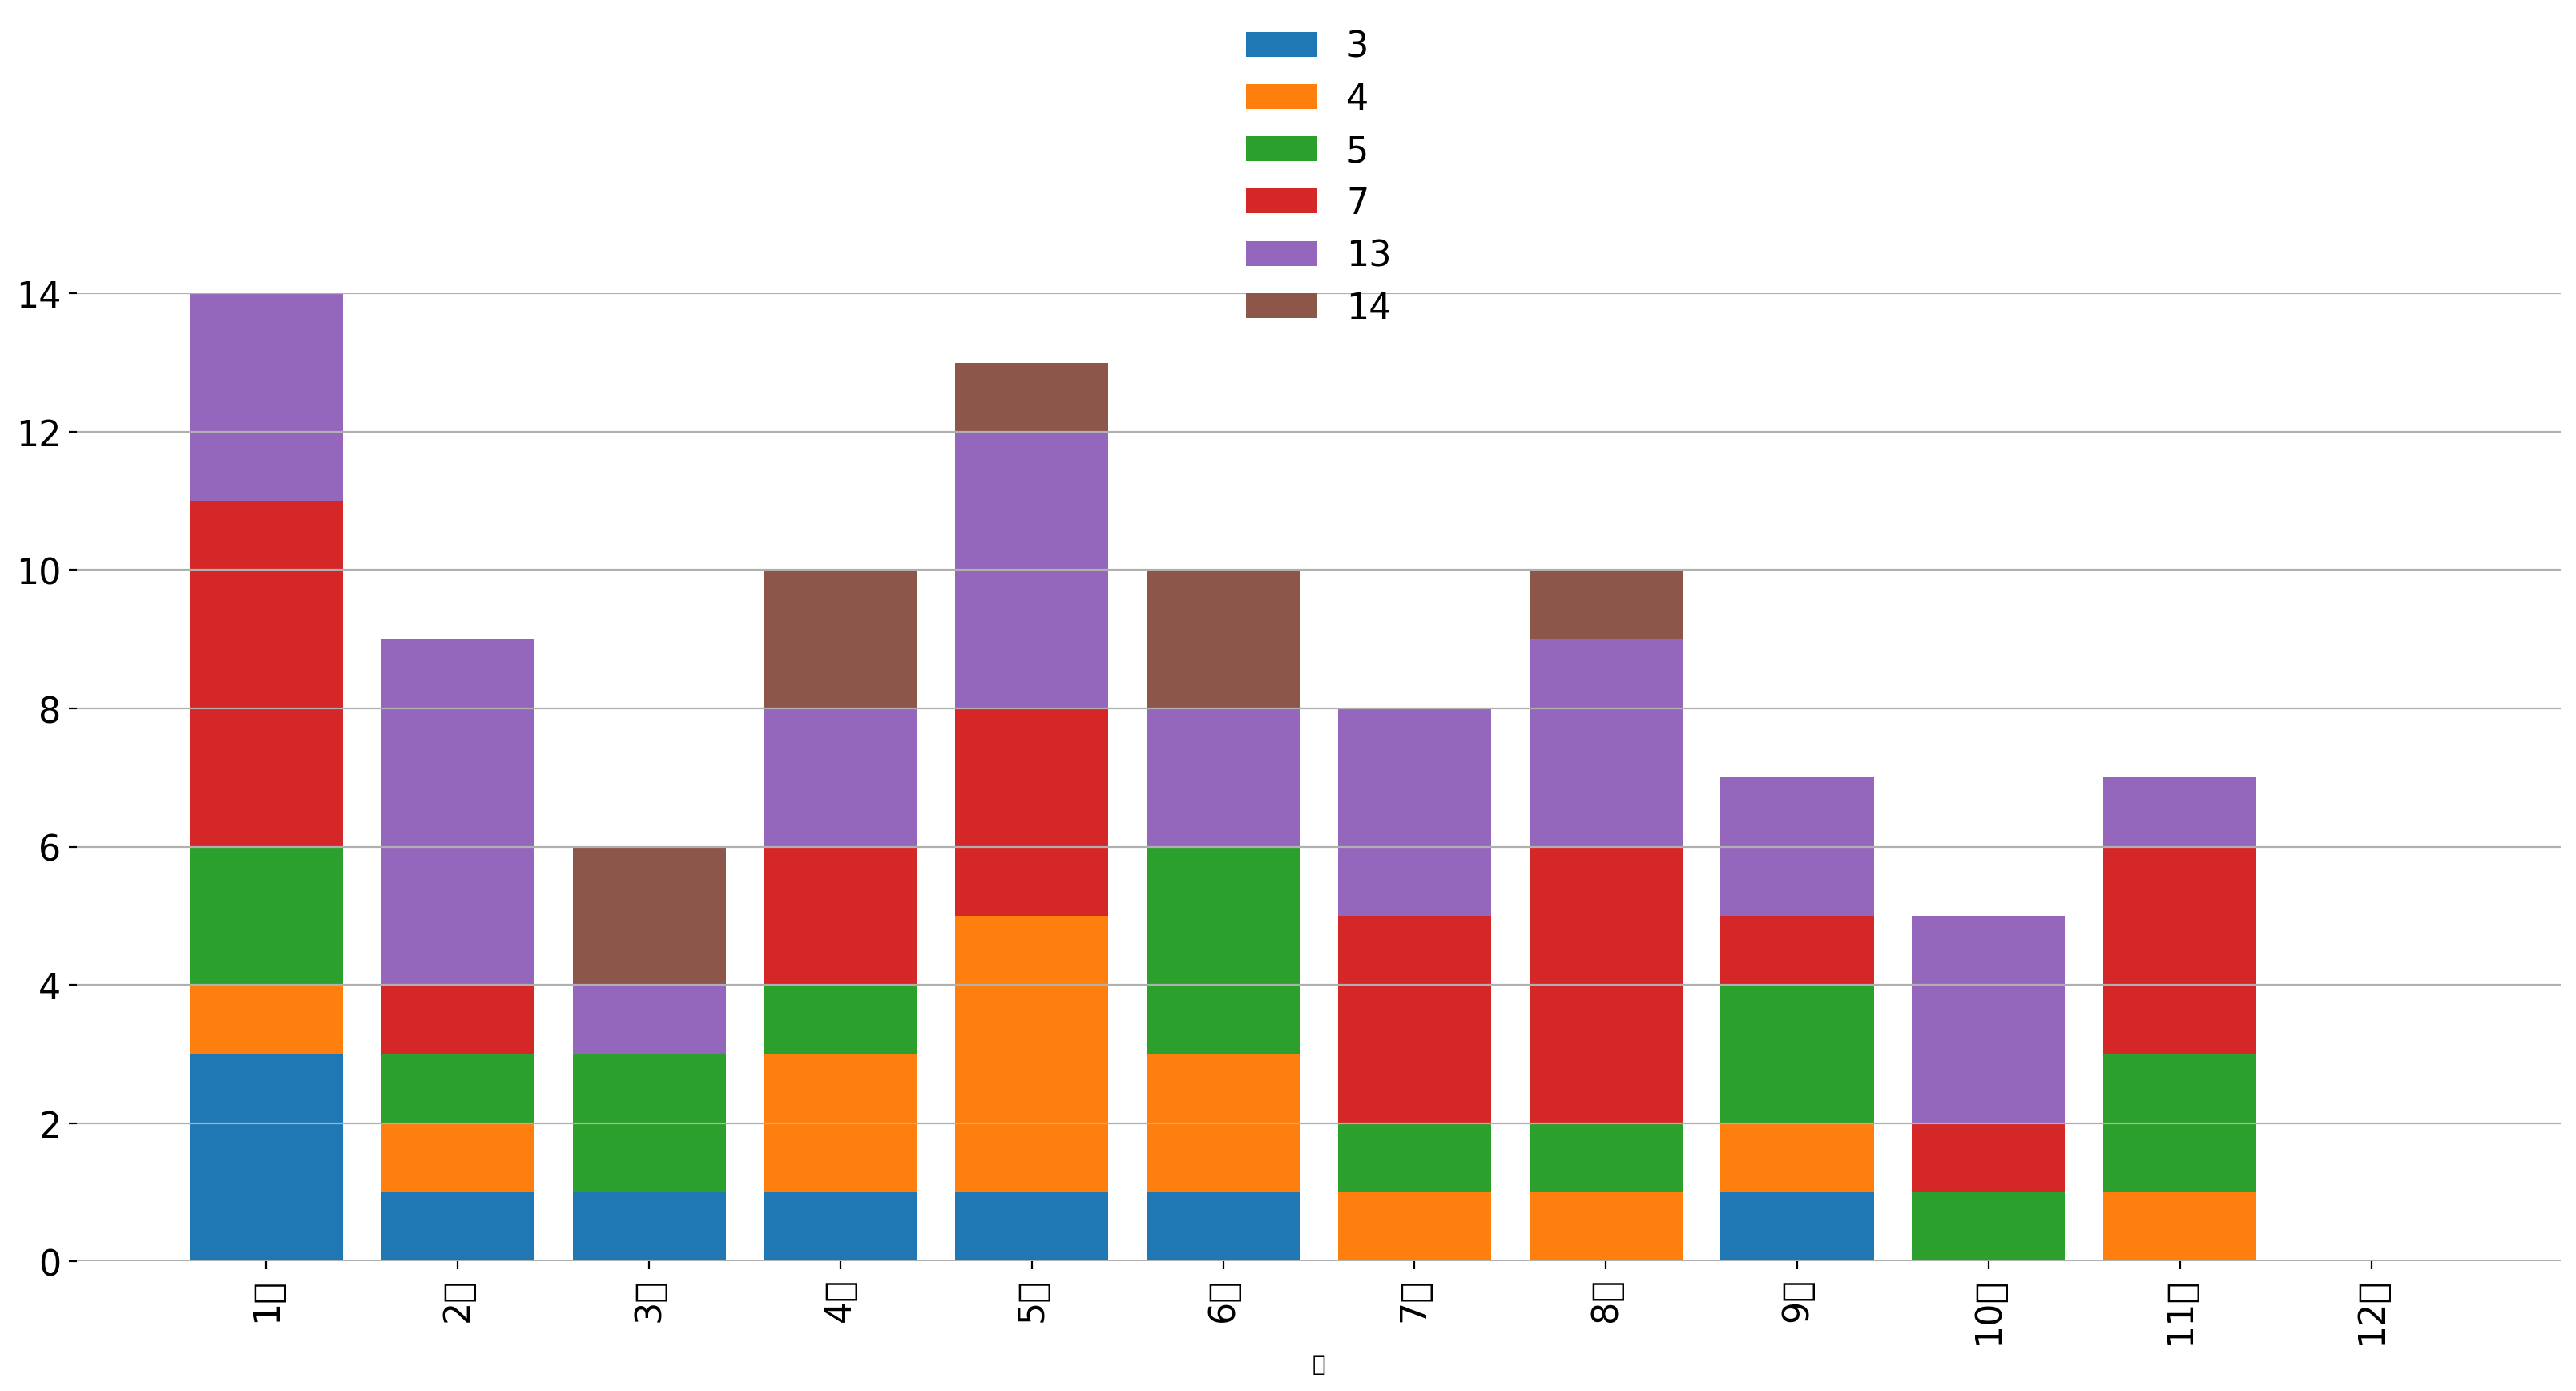

In [45]:
X_col='月'
Y_cols=['3','4','5','7','13','14']
month_graph_df=month_graph_df.rename(columns={3: '3', 4: '4', 5: '5', 7: '7', 13: '13', 14: '14'})
graph.stack_bar(X_col, Y_cols,month_graph_df)
print(month_graph_df['sum'].sum())

In [46]:
month_graph_df['sum'].sum()

99.0

## dateのデータを用いた予測機のテスト

In [47]:
result_df=pd.read_csv('../csv/train_asiya_date.csv',encoding='utf-8')
result_df=result_df.drop(["Unnamed: 0"],axis=1)

result_df=result_df.drop(['date','day'],axis=1)#現状使わないカラムは削除する

date_cols=['year','month','num_date','range_date','season']
date_df=pd.DataFrame(index=result_df.index)
for col in date_cols:
    date_df[col]=result_df[col]
result_df=result_df.drop('year',axis=1)#yearカラムはデータの切り抜きで使うが学習では使わないがので削除（関数内でdropされないから）
#result_df=result_df.drop(col,axis=1)
#money_col=result_df['money']
#result_df=result_df.drop('money',axis=1)#配当金情報の削除
#result_col=result_df['result_com']
#result_df=result_df.drop('result_com',axis=1)#着の組み合わせ
result_df=making_pred_date_df(result_df)#モデルに突っ込むだけの状態に加工（新人選手の情報、欠損地加工とダミー化）
result_df.to_csv('train_df.csv')
df=result_df
### 学習データのベースを作成(validとtrainに分割)
#学習、テストデータ切り分け(2019,2020のデータを検証用データに、ほかは学習)
df['year']=date_df['year']
valid_df = df[(df['year']==2019) | ((df['year']==2020) )]#2019,2020のデータを検証用データに。
train_df =  df[(df['year']!=2019) & ((df['year']!=2020) )]#そのほかを学習データに

test_df=valid_df[valid_df['year']==2019]
#学習データを切り分けたらyearはいらないから削除する
valid_df=valid_df.drop(['year'],axis=1)
train_df=train_df.drop(['year'],axis=1)
test_df=test_df.drop(['year'],axis=1)
train_money=pd.Series(train_df['money'])
valid_money=pd.Series(valid_df['money'])
test_money=pd.Series(test_df['money'])
#正解の情報はいったんよけておく
money_col=test_df['money']#配当金情報の削除
test_df=test_df.drop('money',axis=1)
result_col=test_df['result_com']#着の組み合わせ
test_df=test_df.drop('result_com',axis=1)


In [48]:
test_df

,racer_1_age,racer_1_ave_st,racer_1_doub,racer_1_rank,racer_2_age,racer_2_ave_st,racer_2_doub,racer_2_rank,racer_3_age,racer_3_ave_st,...,racer_6_bo_90,racer_6_bo_91,racer_6_bo_92,racer_6_bo_93,racer_6_bo_94,racer_6_bo_95,racer_6_bo_96,racer_6_bo_97,racer_6_bo_98,racer_6_bo_99
15171,31.0,0.16,0.453,4,27.0,0.16,0.170,1,51.0,0.20,...,0,0,0,0,0,0,0,0,0,0
15172,52.0,0.18,0.328,3,34.0,0.21,0.121,1,23.0,0.12,...,0,0,0,0,0,0,0,0,0,0
15173,38.0,0.16,0.525,4,57.0,0.22,0.078,2,34.0,0.16,...,0,0,0,0,0,0,0,0,0,0
15174,31.0,0.19,0.344,3,38.0,0.18,0.450,4,34.0,0.20,...,0,0,0,0,0,0,0,0,0,0
15175,32.0,0.20,0.245,2,47.0,0.15,0.388,3,32.0,0.17,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17285,45.0,0.16,0.234,2,39.0,0.18,0.250,2,45.0,0.20,...,0,0,0,0,0,0,0,0,0,0
17286,34.0,0.18,0.404,3,31.0,0.16,0.279,2,54.0,0.16,...,0,0,0,0,0,0,0,0,0,0
17287,32.0,0.19,0.398,3,38.0,0.18,0.349,3,44.0,0.16,...,0,0,0,0,0,0,0,0,0,0
17288,32.0,0.16,0.483,4,52.0,0.17,0.426,3,45.0,0.16,...,0,0,0,0,0,0,0,0,0,0


### 新規作成の予測機の読み込み

In [50]:
model3 = pickle.load(open('../pickle_data/date_model/model_com3_dep7_per140_date.sav', 'rb'))
model5 = pickle.load(open('../pickle_data/date_model/model_com5_dep7_per130_date.sav', 'rb'))
model7 = pickle.load(open('../pickle_data/date_model/model_com7_dep5_per135_date.sav', 'rb'))
model12 = pickle.load(open('../pickle_data/date_model/model_com12_dep5_per115_date.sav', 'rb'))
model13 = pickle.load(open('../pickle_data/date_model/model_com13_dep8_per131_date.sav', 'rb'))
model14= pickle.load(open('../pickle_data/date_model/model_com14_dep6_per130_date.sav', 'rb'))
model21= pickle.load(open('../pickle_data/date_model/model_com21_dep6_per132_date.sav', 'rb'))

model3_pred=model3.predict(test_df)
model5_pred=model5.predict(test_df)
model7_pred=model7.predict(test_df)
model12_pred=model12.predict(test_df)
model13_pred=model13.predict(test_df)
model14_pred=model14.predict(test_df)
model21_pred=model21.predict(test_df)

pred_df=pd.DataFrame({'pred_3':model3_pred,
                        'pred_5':model5_pred,
                        'pred_7':model7_pred,
                      'pred_12':model12_pred,
                        'pred_13':model13_pred,
                        'pred_14':model14_pred,
                        'pred_21':model21_pred
                        },index=test_df.index)
#レースの情報を戻す。
pred_df['result_com']=result_col
pred_df=pd.concat([pred_df, date_df], axis=1)

## 予測があってるかのカラム作成

In [51]:
target_coms=[3,5,7,12,13,14,21]#今回、芦屋で対象の予測組
pred_flags=[]#正答のカラムを作るための結果と予測の比較結果を持ったリスト(正解:1  外れ:0)
for index,row in pred_df.iterrows():
    result=row['result_com']
    flag=0
    for com_num in target_coms:
        if 1==row['pred_{}'.format(com_num)]:#発生あり予測があるか
            if result==com_num:#予測があっているか
                flag=1
            else:
                pass
        else:
            pass
    pred_flags.append(flag)
#予測結果の正答結果を持ったカラムを持たせる。
result_df=pred_df.copy()
result_df['right_pred']=pred_flags
result_df.to_csv('date_analysis_base_new.csv',encoding='utf-8')



#正しく判断できたレースのみを残す（ほんとは投票を行ったものの数農地の割合のほうがよさそうだけど・・）
#グラフをP描画する用のdfを作成する。
right_df=result_df[result_df['right_pred']==1] 
month_graph_df=pd.DataFrame(columns=[3,5,7,12,13,14,21])
for month_num in np.arange(1,13,1):#月の番号
    sp_month_df=right_df[right_df['month']==month_num]#月のデータ
    append_s=sp_month_df['result_com'].value_counts()
    month_graph_df.loc['{}月'.format(month_num)]=append_s
month_graph_df=month_graph_df.fillna(0)
month_graph_df['sum']=month_graph_df[3]+month_graph_df[5]+month_graph_df[7]+month_graph_df[12]+month_graph_df[13]+month_graph_df[14]+month_graph_df[21]
month_graph_df['月']=month_graph_df.index
month_graph_df=month_graph_df.fillna(0)
month_graph_df.to_csv('date_analysis_new.csv',encoding='utf-8')


In [52]:
month_graph_df

,3,5,7,12,13,14,21,sum,月
1月,0.0,0.0,2.0,0.0,1.0,0.0,3.0,6.0,1月
2月,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,2月
3月,3.0,0.0,1.0,0.0,0.0,2.0,0.0,6.0,3月
4月,2.0,2.0,1.0,2.0,0.0,0.0,1.0,8.0,4月
5月,1.0,1.0,2.0,2.0,1.0,0.0,1.0,8.0,5月
6月,0.0,0.0,3.0,4.0,1.0,2.0,1.0,11.0,6月
7月,0.0,1.0,3.0,0.0,1.0,0.0,0.0,5.0,7月
8月,2.0,1.0,0.0,2.0,0.0,3.0,0.0,8.0,8月
9月,0.0,1.0,3.0,3.0,0.0,0.0,0.0,7.0,9月
10月,4.0,2.0,2.0,3.0,0.0,0.0,2.0,13.0,10月


92.0


c:\users\nabe0\desktop\nabepy\env\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 26376 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\nabe0\desktop\nabepy\env\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 26376 missing from current font.
  font.set_text(s, 0, flags=flags)
c:\users\nabe0\desktop\nabepy\env\lib\site-packages\matplotlib\backends\backend_agg.py:176: RuntimeWarning: Glyph 26376 missing from current font.
  font.load_char(ord(s), flags=flags)


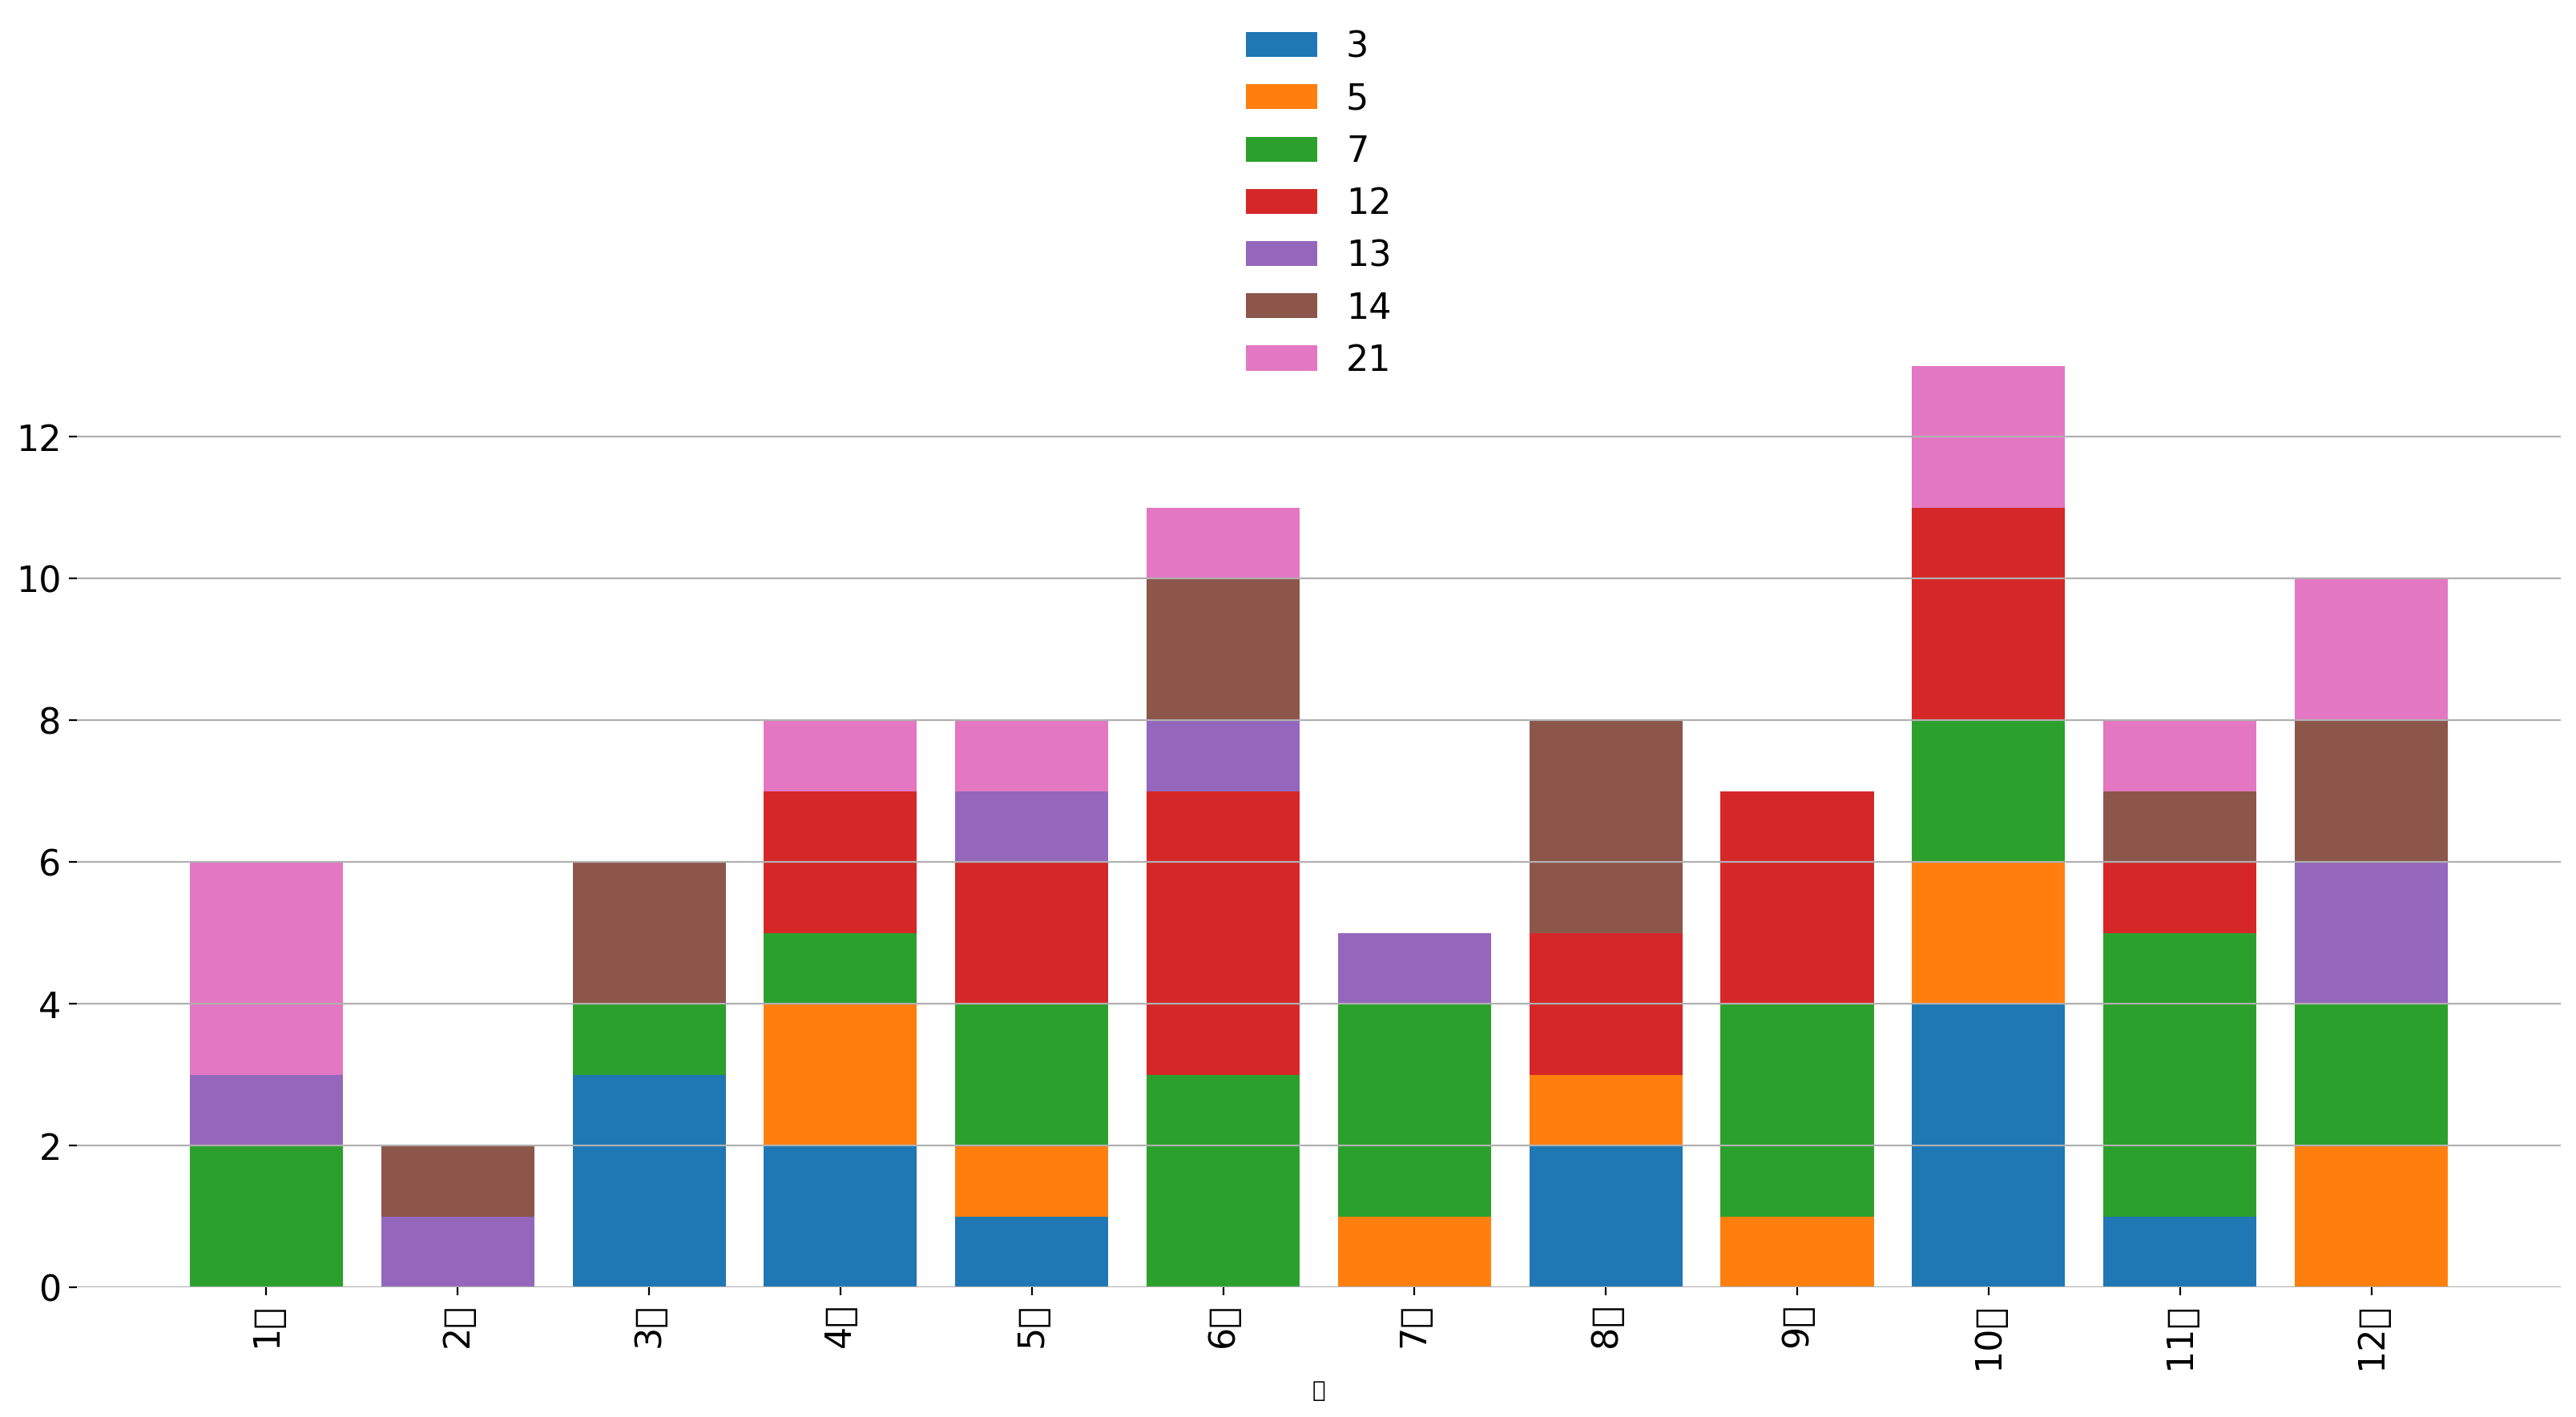

In [53]:
X_col='月'
Y_cols=['3','5','7','12','13','14','21']
month_graph_df=month_graph_df.rename(columns={3: '3', 5: '5', 7: '7',12: '12',  13: '13', 14: '14',21: '21' })
graph.stack_bar(X_col, Y_cols,month_graph_df)
print(month_graph_df['sum'].sum())

In [54]:
month_graph_df['sum'].sum()

92.0

### 2020の検証

In [55]:
result_df=pd.read_csv('../csv/train_asiya_date.csv',encoding='utf-8')
result_df=result_df.drop(["Unnamed: 0"],axis=1)

result_df=result_df.drop(['date','day'],axis=1)#現状使わないカラムは削除する

date_cols=['year','month','num_date','range_date','season']
date_df=pd.DataFrame(index=result_df.index)
for col in date_cols:
    date_df[col]=result_df[col]
result_df=result_df.drop('year',axis=1)#yearカラムはデータの切り抜きで使うが学習では使わないがので削除（関数内でdropされないから）
#result_df=result_df.drop(col,axis=1)
#money_col=result_df['money']
#result_df=result_df.drop('money',axis=1)#配当金情報の削除
#result_col=result_df['result_com']
#result_df=result_df.drop('result_com',axis=1)#着の組み合わせ
result_df=making_pred_date_df(result_df)#モデルに突っ込むだけの状態に加工（新人選手の情報、欠損地加工とダミー化）
result_df.to_csv('train_df.csv')
df=result_df
### 学習データのベースを作成(validとtrainに分割)
#学習、テストデータ切り分け(2019,2020のデータを検証用データに、ほかは学習)
df['year']=date_df['year']
valid_df = df[(df['year']==2019) | ((df['year']==2020) )]#2019,2020のデータを検証用データに。
train_df =  df[(df['year']!=2019) & ((df['year']!=2020) )]#そのほかを学習データに
test_df=valid_df[valid_df['year']==2020]
#学習データを切り分けたらyearはいらないから削除する
valid_df=valid_df.drop(['year'],axis=1)
train_df=train_df.drop(['year'],axis=1)
test_df=test_df.drop(['year'],axis=1)
train_money=pd.Series(train_df['money'])
valid_money=pd.Series(valid_df['money'])
test_money=pd.Series(test_df['money'])
#正解の情報はいったんよけておく
money_col=test_df['money']#配当金情報の削除
test_df=test_df.drop('money',axis=1)
result_col=test_df['result_com']#着の組み合わせ
test_df=test_df.drop('result_com',axis=1)
model3 = pickle.load(open('../pickle_data/date_model/model_com3_dep7_per140_date.sav', 'rb'))
model5 = pickle.load(open('../pickle_data/date_model/model_com5_dep7_per130_date.sav', 'rb'))
model7 = pickle.load(open('../pickle_data/date_model/model_com7_dep5_per135_date.sav', 'rb'))
model12 = pickle.load(open('../pickle_data/date_model/model_com12_dep5_per115_date.sav', 'rb'))
model13 = pickle.load(open('../pickle_data/date_model/model_com13_dep8_per131_date.sav', 'rb'))
model14= pickle.load(open('../pickle_data/date_model/model_com14_dep6_per130_date.sav', 'rb'))
model21= pickle.load(open('../pickle_data/date_model/model_com21_dep6_per132_date.sav', 'rb'))

model3_pred=model3.predict(test_df)
model5_pred=model5.predict(test_df)
model7_pred=model7.predict(test_df)
model12_pred=model12.predict(test_df)
model13_pred=model13.predict(test_df)
model14_pred=model14.predict(test_df)
model21_pred=model21.predict(test_df)

pred_df=pd.DataFrame({'pred_3':model3_pred,
                        'pred_5':model5_pred,
                        'pred_7':model7_pred,
                      'pred_12':model12_pred,
                        'pred_13':model13_pred,
                        'pred_14':model14_pred,
                        'pred_21':model21_pred
                        },index=test_df.index)
#レースの情報を戻す。
pred_df['result_com']=result_col
pred_df=pd.concat([pred_df, date_df], axis=1)
target_coms=[3,5,7,12,13,14,21]#今回、芦屋で対象の予測組
pred_flags=[]#正答のカラムを作るための結果と予測の比較結果を持ったリスト(正解:1  外れ:0)
for index,row in pred_df.iterrows():
    result=row['result_com']
    flag=0
    for com_num in target_coms:
        if 1==row['pred_{}'.format(com_num)]:#発生あり予測があるか
            if result==com_num:#予測があっているか
                flag=1
            else:
                pass
        else:
            pass
    pred_flags.append(flag)
#予測結果の正答結果を持ったカラムを持たせる。
result_df=pred_df.copy()
result_df['right_pred']=pred_flags
result_df.to_csv('date_analysis_base_new.csv',encoding='utf-8')



#正しく判断できたレースのみを残す（ほんとは投票を行ったものの数農地の割合のほうがよさそうだけど・・）
#グラフをP描画する用のdfを作成する。
right_df=result_df[result_df['right_pred']==1] 
month_graph_df=pd.DataFrame(columns=[3,5,7,12,13,14,21])
for month_num in np.arange(1,13,1):#月の番号
    sp_month_df=right_df[right_df['month']==month_num]#月のデータ
    append_s=sp_month_df['result_com'].value_counts()
    month_graph_df.loc['{}月'.format(month_num)]=append_s
month_graph_df=month_graph_df.fillna(0)
month_graph_df['sum']=month_graph_df[3]+month_graph_df[5]+month_graph_df[7]+month_graph_df[12]+month_graph_df[13]+month_graph_df[14]+month_graph_df[21]
month_graph_df['月']=month_graph_df.index
month_graph_df=month_graph_df.fillna(0)
month_graph_df.to_csv('date_analysis_new.csv',encoding='utf-8')


In [56]:
month_graph_df

,3,5,7,12,13,14,21,sum,月
1月,2.0,0.0,5.0,2.0,1.0,0.0,1.0,11.0,1月
2月,1.0,1.0,1.0,2.0,4.0,0.0,0.0,9.0,2月
3月,1.0,2.0,0.0,0.0,0.0,2.0,1.0,6.0,3月
4月,1.0,1.0,1.0,0.0,1.0,3.0,1.0,8.0,4月
5月,0.0,0.0,3.0,3.0,2.0,1.0,1.0,10.0,5月
6月,1.0,1.0,1.0,3.0,2.0,2.0,2.0,12.0,6月
7月,0.0,0.0,3.0,3.0,2.0,0.0,1.0,9.0,7月
8月,0.0,0.0,3.0,3.0,0.0,1.0,2.0,9.0,8月
9月,0.0,2.0,1.0,1.0,1.0,0.0,0.0,5.0,9月
10月,0.0,1.0,1.0,0.0,1.0,0.0,1.0,4.0,10月


91.0


c:\users\nabe0\desktop\nabepy\env\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 26376 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\nabe0\desktop\nabepy\env\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 26376 missing from current font.
  font.set_text(s, 0, flags=flags)
c:\users\nabe0\desktop\nabepy\env\lib\site-packages\matplotlib\backends\backend_agg.py:176: RuntimeWarning: Glyph 26376 missing from current font.
  font.load_char(ord(s), flags=flags)


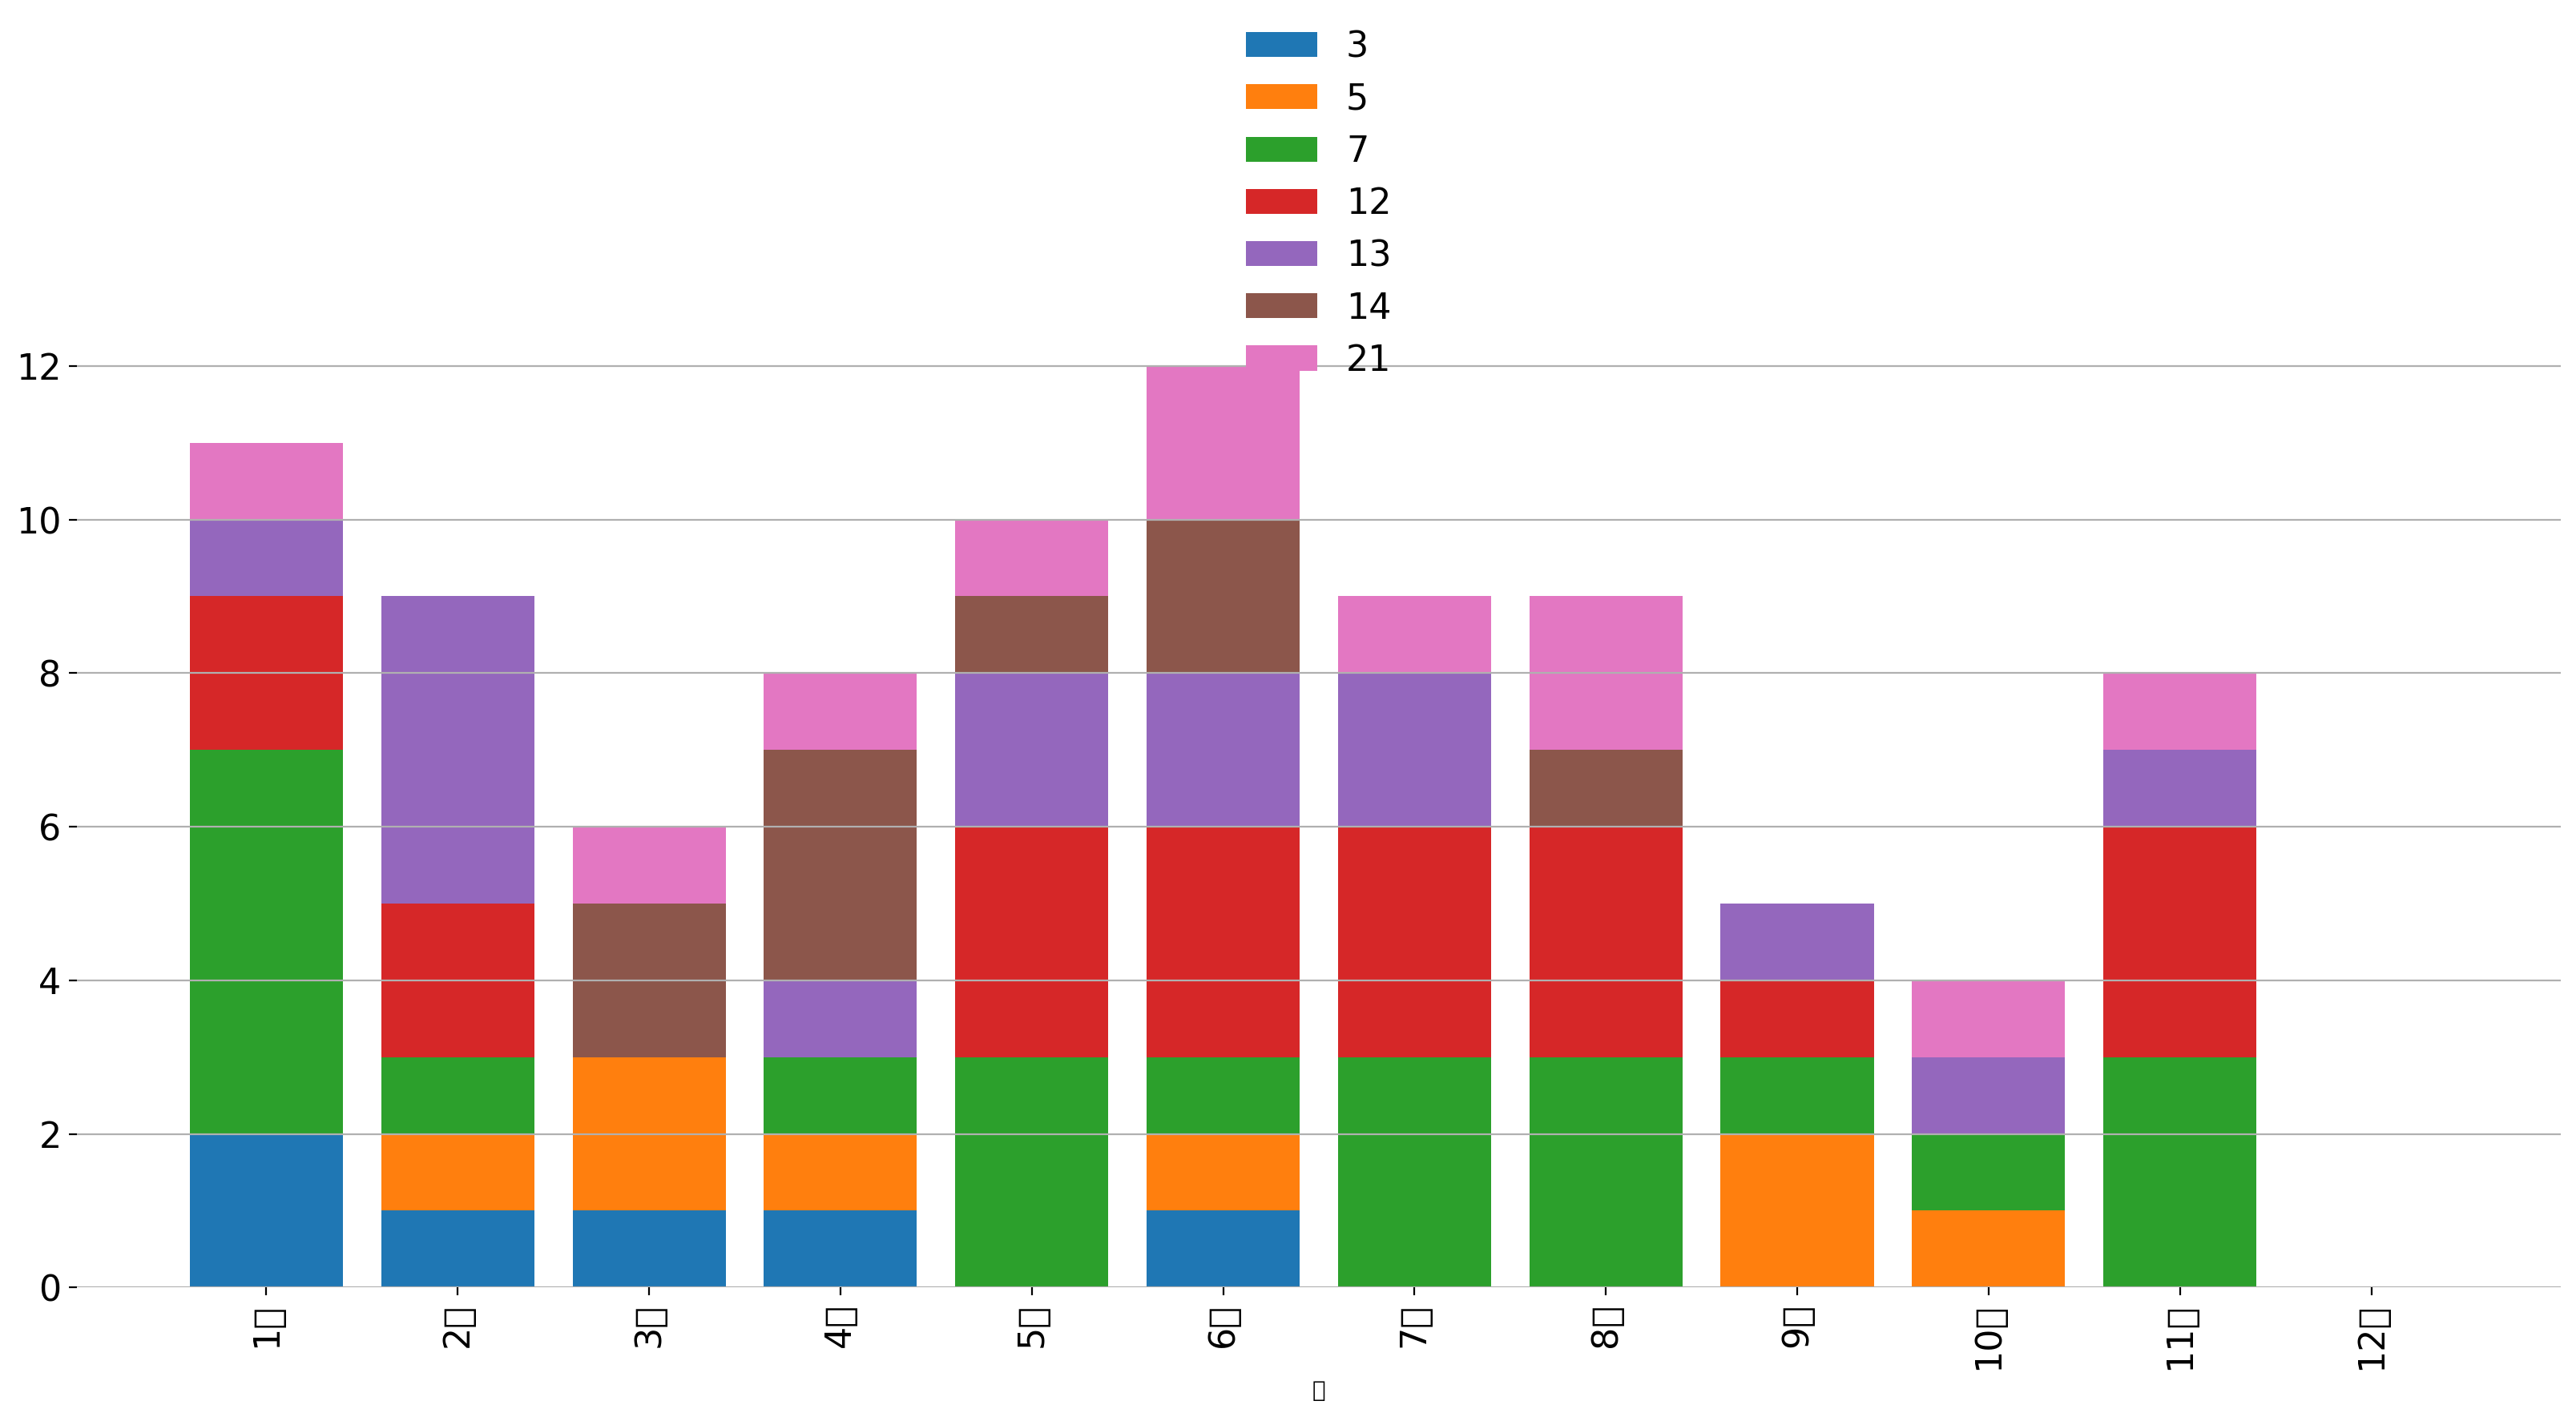

In [57]:
X_col='月'
Y_cols=['3','5','7','12','13','14','21']
month_graph_df=month_graph_df.rename(columns={3: '3', 5: '5', 7: '7',12: '12',  13: '13', 14: '14',21: '21' })
graph.stack_bar(X_col, Y_cols,month_graph_df)
print(month_graph_df['sum'].sum())